# The Good, The Bad, and The Ugly (spatial map of EZ/PZ/HZ)

While all the models are wrong, but good to know the useful one!


The influence of prior on WAIC and PSIS-LOO to infer the correct epileptogenicity hypothesis

In [1]:
import os
import sys
import errno
import time

import numpy as np
import pandas as pd
import seaborn as sns
import pystan

In [2]:
from scipy.optimize import fsolve
from scipy.optimize import root

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [4]:
%pylab inline
#%matplotlib notebook
plt.style.use('default')

Populating the interactive namespace from numpy and matplotlib


In [5]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

# Generate Data

In [6]:
random.seed(42)

In [7]:
Nt, Tend, sigma = 5000,50.0, 1e-1

In [8]:
dt=Tend/Nt
print ('dt=', dt)

dt= 0.01


In [9]:
tau0=10.0
I1=3.1

In [10]:
x_init=-1.5
z_init=3.5

In [11]:
f_decim=10

In [12]:
def Epileptor2D(Nt, dt, f_decim, x_init, z_init, tau0, eta_true):
    xs, zs = [x_init], [z_init]

    for i in range(Nt-1):
        x, z = xs[-1], zs[-1]
        dx =1.0 - x**3 - 2.0*x**2 - z + I1   
        dz =(1.0/tau0)*(4*(x-eta_true) - z)
        xs.append(x + dt * dx + sqrt(dt) * sigma * randn())
        zs.append(z + dt * dz + sqrt(dt) * sigma * randn())

    xs,zs = array(xs), array(zs)

    xs,zs = array(xs)+sigma*randn(xs.size), array(zs)+sigma*randn(zs.size)

    obs= array([xs, zs]).transpose()
    ts = dt*r_[:xs.shape[0]]
    
    obs_decim, ts_decim= obs[::f_decim], ts[::f_decim]
    
    return ts_decim, obs_decim

In [13]:
def nullclines(X,Y, eta, tau0):   
    dX =  1.0 - X**3 - 2.0*X**2 - Y + I1 
    dY =  (1.0/tau0)*(4*(X-eta) - Y)
    contour(X, Y, dX, 0, colors='r')
    contour(X, Y, dY, 0, colors='b')

In [14]:
def root_fuc(roots, eta, tau0):   
    x = empty(1)
    z = empty(1)
    F = empty(2)
    x = roots[0]
    z = roots[1]
    F[0] =1.0 - x**3 - 2.0*x**2 - z + I1 
    F[1] =(1.0/tau0)*(4*(x-eta) - z)
    return F

In [15]:
rGuess=array([[-1.,3.]])
X, Z = mgrid[-5.0:5.0:100j, 0.0:10.0:100j]

/home/meysam/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


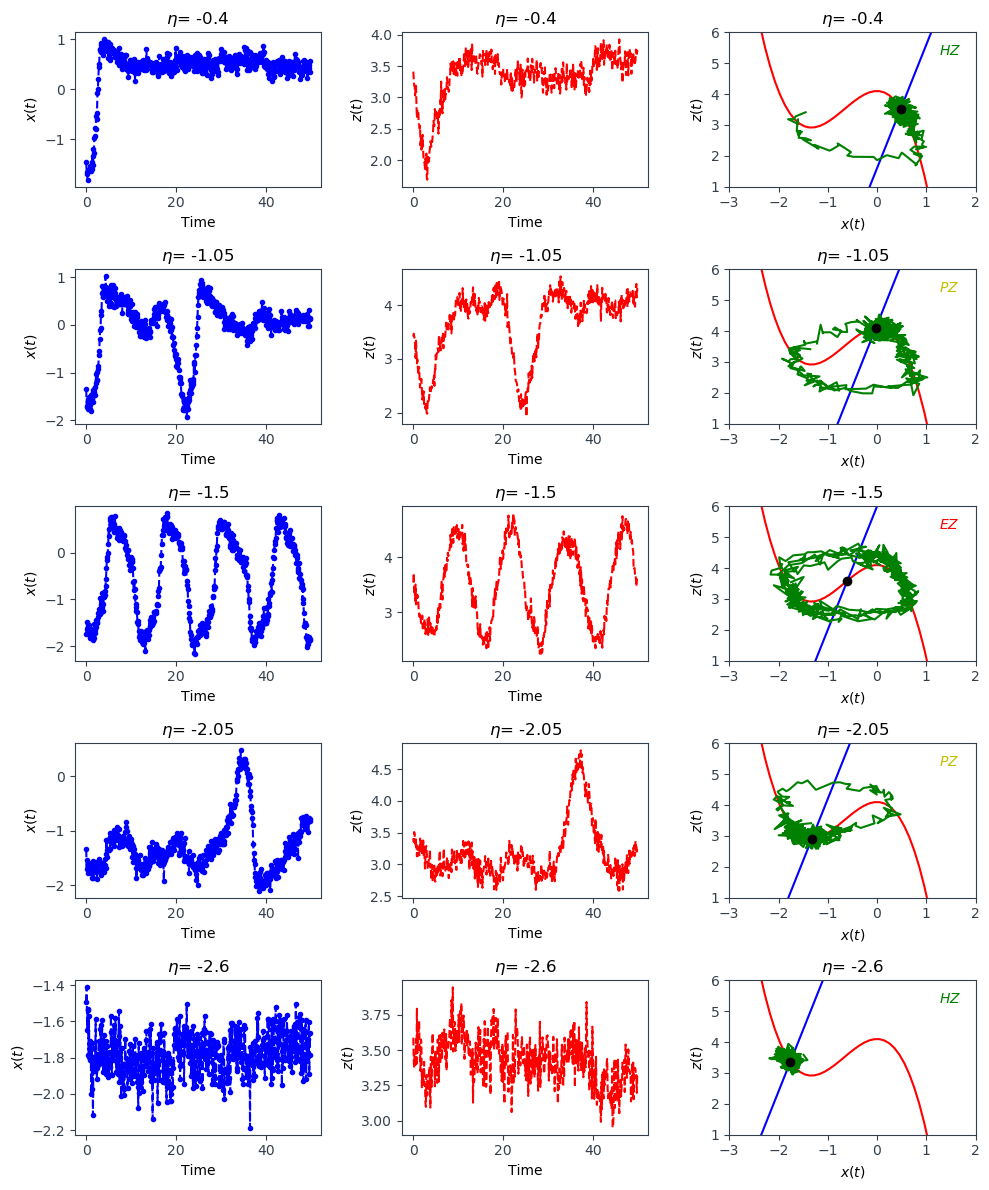

In [16]:
plt.figure(figsize=(10, 12))

for idx, eta_val in enumerate([-.4, -1.05, -1.5, -2.05, -2.6]):
        ts_decim, obs_decim=Epileptor2D(Nt, dt, f_decim, x_init, z_init, tau0, eta_val)
        plt.subplot(5,3,3*idx+1)
        plot(ts_decim, obs_decim[:,0], '--b.')
        plt.xlabel('Time'); plt.ylabel(r'$x(t)$'); 
        plt.title('$\eta$= %s' %eta_val)
        plt.subplot(5,3,3*idx+2)
        plot(ts_decim, obs_decim[:,1], '--r')
        plt.xlabel('Time'); plt.ylabel(r'$z(t)$'); 
        plt.title('$\eta$= %s' %eta_val)
        plt.subplot(5,3,3*idx+3)
        plot(obs_decim[:,0], obs_decim[:,1], 'g')
        true_roots = fsolve(root_fuc,rGuess, args=(eta_val, tau0))
        nullclines(X,Z,  eta_val, tau0)
        plt.plot(true_roots[0],true_roots[1] , marker="o", markersize=6, color='k')
        plt.xlim((-3,2)), plt.ylim((1,6))
        plt.xlabel(r'$x(t)$'); plt.ylabel(r'$z(t)$'); 
        plt.title('$\eta$= %s' %eta_val)
        
        if -2.05<eta_val<-1.05:
            plt.text(1.25, 5.25, r'$EZ$', color='r')
        elif -2.5<=eta_val<=-2.05 or -1.05<=eta_val<=-.5:
            plt.text(1.25, 5.25, r'$PZ$', color='y')  
        else:   
            plt.text(1.25, 5.25, r'$HZ$', color='g')     
plt.tight_layout()

## EZ hypothesis

In [17]:
eta_true=-1.5

ts_decim, obs_decim=Epileptor2D(Nt, dt, f_decim, x_init, z_init, tau0, eta_true)

In [18]:
obs_decim.shape, ts_decim.shape

((500, 2), (500,))

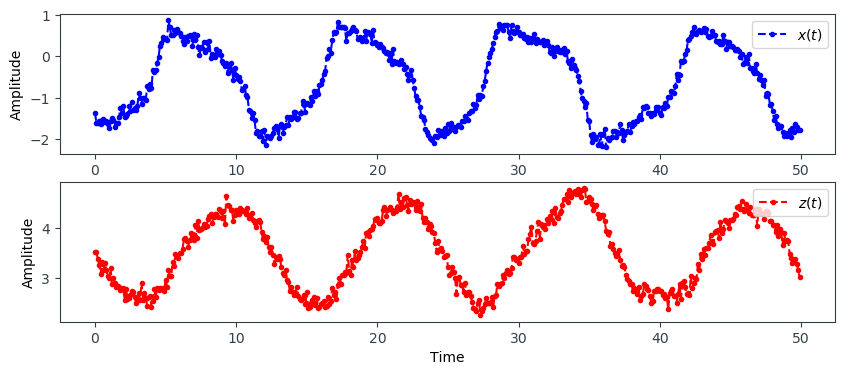

In [19]:
plt.figure(figsize=(10, 4))
plt.subplot(211)
plot(ts_decim, obs_decim[:,0], '--b.', label='$x(t)$')
plt.xlabel('Time'); plt.ylabel('Amplitude'); 
plt.legend(loc='upper right')
plt.subplot(212)
plot(ts_decim, obs_decim[:,1], '--r.', label='$z(t)$')
plt.xlabel('Time'); plt.ylabel('Amplitude'); 
plt.legend(loc='upper right')
plt.show()

In [20]:
nt=obs_decim[:,0].shape[0]
dt_decim=ts_decim[1]-ts_decim[0]
print ('dt_decim=', dt_decim)

dt_decim= 0.1


In [21]:
nt, ts_decim.shape

(500, (500,))

# Generate SweepData 2D  (mu,sd) to run Stan 

In [22]:
cwd = os.getcwd()
cwd

'/data/meysam/VepSyntheticData/BVEP_Benchmarking/EpileptorInferEZHypos_HMC'

In [23]:
sd_value=0.0
mu_value=0.0

In [24]:
data_dict= {
    'nt': nt, 'dt': dt_decim, 
    'xs': obs_decim[:,0], 'zs': obs_decim[:,1], 
    'tau0': tau0,  'I1': I1, 'eta_true':eta_true,
    'xlim': r_[-3.0, 2.0],'zlim': r_[0.0, 10.0],
    'eta_mu': mu_value, 'eta_sd': sd_value,
}

nd=[]
npz = {'nd': nd}
npz.update(data_dict)

savez('data_input2D.npz', **npz)
savez('data_input2D.R.npz', **npz)
pystan.stan_rdump(data_dict, 'data_input2D.R')

In [25]:
filename = "data_input2D"

if filename in os.listdir(cwd):
    print('Directory Exists')

if not os.path.exists(os.path.join(cwd, filename)):
    try:
        os.mkdir(os.path.join(cwd, filename))
    except OSError as exception: 
        if exception.errno != errno.EEXIST:
            raise

Directory Exists


In [26]:
cwd_datainput= os.path.join(cwd, filename)

In [27]:
npz.update(data_dict)

In [28]:
sd_values=array([0.01,  0.025, 0.05, 0.1, 0.5, 1.0, 2.0, 10., 100., 1000.])
mu_values=array([-6.0, -5.5, -5.0, -4.5, -4.0, -3.5,-3.0, -2.5, -2.0,  -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0,  2.5 , 3.0])

In [29]:
idx_R=0
for i in range(1,len(mu_values)+1):
     for j in range(1,len(sd_values)+1):
                npz.update({"eta_mu": mu_values[i-1]})
                npz.update({"eta_sd": sd_values[j-1]})
                #print ('eta_mu=', mu_values[i-1])
                #print ('eta_sd=', sd_values[j-1])
                idx_R= idx_R+1
                #print  ('idx=', (idx_R))
                "data_input2D" + str(idx_R) + ".R.npz"
                "data_input2D%s.R.npz" % idx_R
                file_name_npz="data_input2D{}.npz".format(idx_R)
                savez(os.path.join(cwd_datainput, file_name_npz), **npz)
                
                file_name_Rnpz="data_input2D{}.R.npz".format(idx_R)
                savez(os.path.join(cwd_datainput, file_name_Rnpz), **npz)
                
                file_name_R="data_input2D{}.R".format(idx_R)
                os.chdir(cwd_datainput)
                pystan.stan_rdump( npz, file_name_R)

In [30]:
%cd ..

/data/meysam/VepSyntheticData/BVEP_Benchmarking/EpileptorInferEZHypos_HMC


# Run Cross-Validation Epiletor2D

In [31]:
cat Epileptor2D_Hypos.stan

data {
    int nt;
    real dt;
    vector[nt] xs;
    real xlim[2];
    real zlim[2];
    real I1;
    real tau0;
    real eta_sd; 
    real eta_mu;
}

transformed data {
}

parameters {
    vector<lower=xlim[1], upper=xlim[2]>[nt] x;
    vector<lower=zlim[1], upper=zlim[2]>[nt] z;
    real eta;  
    real <lower=0.0> amplitude;
    real offset; 
    real<lower=0.0> eps;   
    real<lower=0.0> sig;
    real<lower=0.0, upper=1.> tt;
}

model {
    vector[nt] xhat;

    x[1] ~ normal(-1.5, 1.);
    z[1] ~ normal(3.5, 1.);
                         
    eta ~ normal(eta_mu, eta_sd); 

    amplitude ~ normal(1.,1.);
    offset ~ normal(0., 1.);
    eps ~ normal(0., 1.); 
    sig ~ normal(0., 1.);
    tt ~ normal(0., 1.0); 


    for (t in 1:(nt-1)) {
            real dx = 1.0 - x[t]*x[t]*x[t] - 2.0*x[t]*x[t] - z[t] + I1;
            real dz = (1.0/tau0)*(4*(x[t] - eta) - z[t] );
            x[t+1] ~ normal(x[t] + tt*dt*dx, sqrt(tt*dt)*sig); 
            z[t+1] ~ normal(z[t] + tt*dt*dz, sqr

Run the models in bash:

In [32]:
# %%bash

# ./RunCVHypos.sh

**calculate CV**

In [33]:
%%bash

model=Epileptor2D_Hypos
alg=hmc

python ComputeWAIC_Hypos.py   data_input2D    ${model}  data_output_CV_${alg}_${model}

python ComputePSIS_Hypos.py   data_input2D    ${model}  data_output_CV_${alg}_${model}

/data/meysam/VepSyntheticData/BVEP_Benchmarking/EpileptorInferEZHypos_HMC/data_output_CV_hmc_Epileptor2D_Hypos
............................................................
............................................................
Writing WAIC completed
/data/meysam/VepSyntheticData/BVEP_Benchmarking/EpileptorInferEZHypos_HMC/data_output_CV_hmc_Epileptor2D_Hypos
............................................................
............................................................
Writing PSIS-LOO completed


**Plot CV**

In [34]:
import re
import glob
from operator import itemgetter

cwd = os.getcwd()
os.chdir(cwd)

numbers = re.compile(r'(\d+)')

def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [35]:
allNpzFiles = sorted(glob.glob(cwd + "/*.npz"), key=numericalSort)

allNpzFiles

['/data/meysam/VepSyntheticData/BVEP_Benchmarking/EpileptorInferEZHypos_HMC/Outfile_PSIS_CV_data_input2D_Epileptor2D_Hypos.npz',
 '/data/meysam/VepSyntheticData/BVEP_Benchmarking/EpileptorInferEZHypos_HMC/Outfile_WAIC_CV_data_input2D_Epileptor2D_Hypos.npz',
 '/data/meysam/VepSyntheticData/BVEP_Benchmarking/EpileptorInferEZHypos_HMC/data_input2D.R.npz',
 '/data/meysam/VepSyntheticData/BVEP_Benchmarking/EpileptorInferEZHypos_HMC/data_input2D.npz']

## Plot the WAIC/PSIS-LOO

In [36]:
Outputfiles= [x.rsplit('/')[-1].rsplit('.npz')[-2] for x in allNpzFiles if  'Epileptor2D' and "CV" in x]
Outputfiles

['Outfile_PSIS_CV_data_input2D_Epileptor2D_Hypos',
 'Outfile_WAIC_CV_data_input2D_Epileptor2D_Hypos']

In [37]:
Nchain=4

In [38]:
Outfile_WAIC=[]
Outfile_PSIS=[]

elpd_waic_values=[]
p_waic_values=[]
loo_values=[]

for file in Outputfiles:
    
    if "WAIC" in file:
            Outfile_WAIC.append(file)
            npz=load(str(file)+'.npz')
            elpd_waic=npz['elpd_waic_values']
            p_waic=npz['p_waic_values']
            elpd_waic_values.append(elpd_waic)
            p_waic_values.append(p_waic)

    if "PSIS" in file:
            Outfile_PSIS.append(file)
            npz=load(str(file)+'.npz')
            loo=npz['loo_values']
            loo_values.append(loo)
   

In [39]:
waic_values = [i * -2 for i in elpd_waic_values]

In [40]:
elpd_waic_values=asarray(elpd_waic_values)
p_waic_values=asarray(p_waic_values)
loo_values=asarray(loo_values)

In [41]:
p_waic_values_mean=mean(p_waic_values.reshape(-1, Nchain), axis=1)
elpd_waic_values_mean=mean(elpd_waic_values.reshape(-1, Nchain), axis=1)
loo_values_mean=mean(loo_values.reshape(-1, Nchain), axis=1)

/home/meysam/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/meysam/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


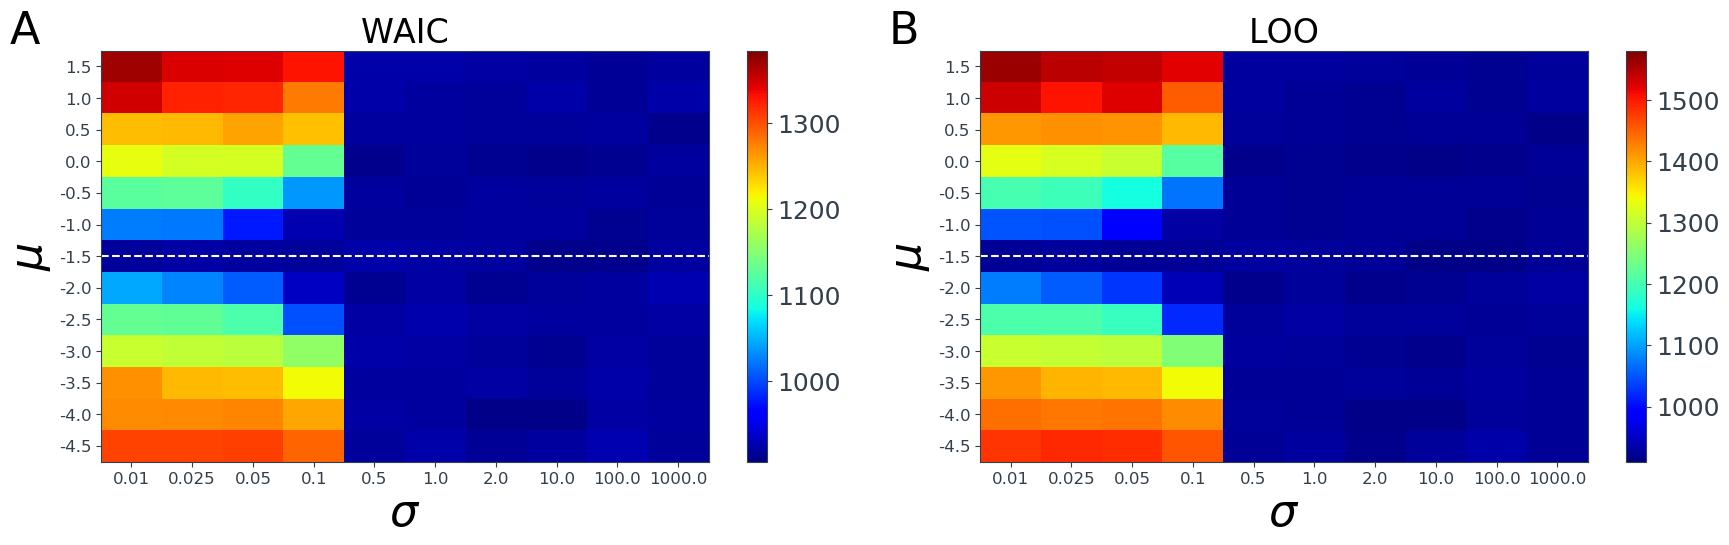

In [42]:
fig=figure(figsize=(18,6))

plt.subplot(121)
imshow((-2*elpd_waic_values_mean).reshape(len(mu_values),len(sd_values)), aspect='auto',  origin='lower', cmap='jet')
plt.hlines(y=9., xmin=-.5, xmax=9.5, linewidth=1.5, color = 'w', linestyle='--' )
cb = plt.colorbar()
cb.ax.tick_params(labelsize=18)
plt.yticks(r_[:len(mu_values)], mu_values,  fontsize=12);
plt.xticks(r_[:len(sd_values)], sd_values,  fontsize=12);
plt.ylim((2.5,15.5))
plt.xlabel("$\sigma$",  fontsize=32)
plt.ylabel("$\mu$",  fontsize=32)
plt.title('WAIC',  fontsize=24)


plt.subplot(122)
imshow((-2*(loo_values_mean)).reshape(len(mu_values),len(sd_values)), aspect='auto',  origin='lower', cmap='jet')
plt.hlines(y=9., xmin=-.5, xmax=9.5, linewidth=1.5, color = 'w', linestyle='--' )
cb = plt.colorbar()
cb.ax.tick_params(labelsize=18)
plt.yticks(r_[:len(mu_values)], mu_values,  fontsize=12);
plt.xticks(r_[:len(sd_values)], sd_values,  fontsize=12, rotation="horizontal");
plt.ylim((2.5,15.5))
plt.xlabel("$\sigma$",  fontsize=32)
plt.ylabel("$\mu$",  fontsize=32)
plt.title('LOO',  fontsize=24)


for i, label in enumerate(('A', 'B')):
    ax = fig.add_subplot(1,2,i+1)
    ax.text(-0.1, 1.1, label, transform=ax.transAxes,
    fontsize=32, fontweight='medium', va='top', ha='right')
    
    
fig.tight_layout(pad=2.5, w_pad=2, h_pad=3.)
plt.savefig("Fig_epileptor_sweepprior.png",dpi=800)
plt.show()

/home/meysam/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/meysam/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


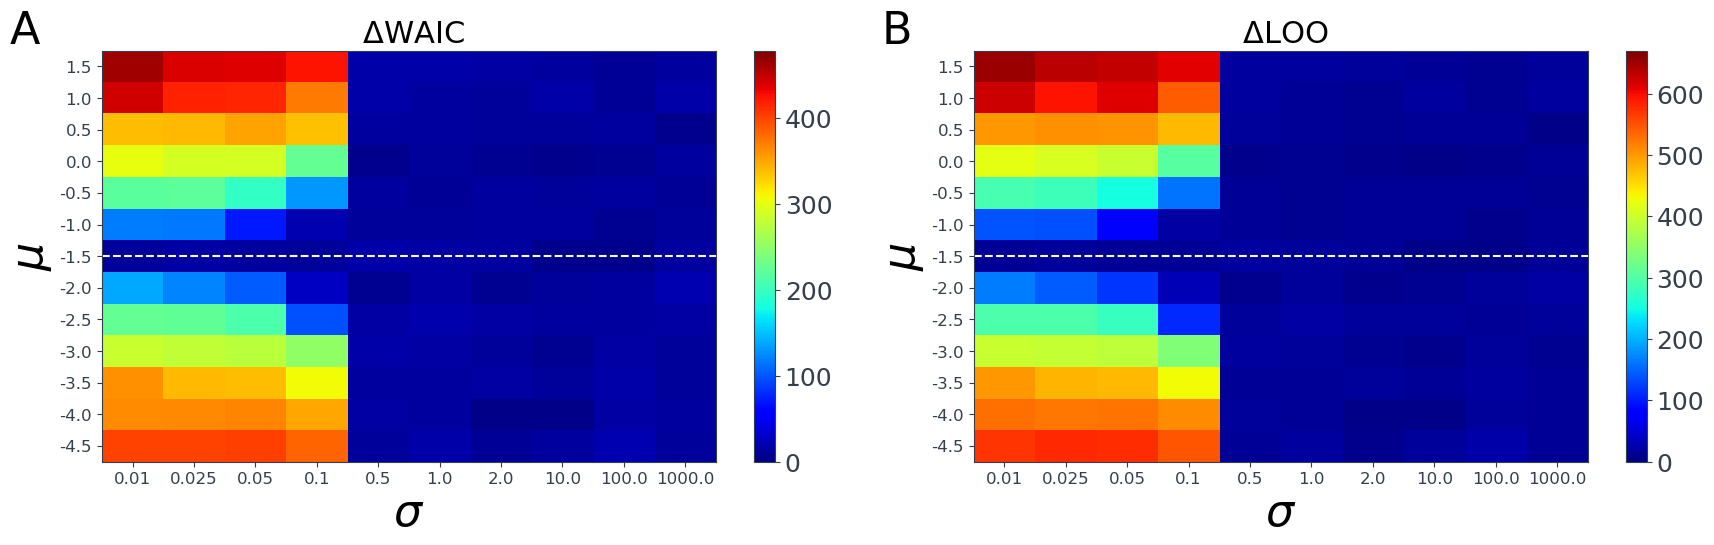

In [43]:
fig=figure(figsize=(18,6))

plt.subplot(121)
imshow((-2*elpd_waic_values_mean).reshape(len(mu_values),len(sd_values))-(-2*elpd_waic_values_mean).reshape(len(mu_values),len(sd_values)).min(), aspect='auto',  origin='lower', cmap='jet')
plt.hlines(y=9., xmin=-.5, xmax=9.5, linewidth=1.5, color = 'w', linestyle='--' )
cb = plt.colorbar()
cb.ax.tick_params(labelsize=18)
plt.yticks(r_[:len(mu_values)], mu_values,  fontsize=12);
plt.xticks(r_[:len(sd_values)], sd_values,  fontsize=12);
plt.ylim((2.5,15.5))
plt.xlabel("$\sigma$",  fontsize=32)
plt.ylabel("$\mu$",  fontsize=32)
plt.title(r' ${\rm \Delta WAIC}$',  fontsize=22)

plt.subplot(122)
imshow((-2*loo_values_mean).reshape(len(mu_values),len(sd_values))-(-2*loo_values_mean).reshape(len(mu_values),len(sd_values)).min(), aspect='auto',  origin='lower', cmap='jet')
plt.hlines(y=9., xmin=-.5, xmax=9.5, linewidth=1.5, color = 'w', linestyle='--' )
cb = plt.colorbar()
cb.ax.tick_params(labelsize=18)
plt.yticks(r_[:len(mu_values)], mu_values,  fontsize=12);
plt.xticks(r_[:len(sd_values)], sd_values,  fontsize=12, rotation="horizontal");
plt.ylim((2.5,15.5))
plt.xlabel("$\sigma$",  fontsize=32)
plt.ylabel("$\mu$",  fontsize=32)
plt.title(r' ${\rm \Delta LOO}$',  fontsize=22)

for i, label in enumerate(('A', 'B')):
    ax = fig.add_subplot(1,2,i+1)
    ax.text(-0.1, 1.1, label, transform=ax.transAxes,
    fontsize=32, fontweight='medium', va='top', ha='right')
    
    
fig.tight_layout(pad=2.5, w_pad=2, h_pad=3.)
plt.savefig("Fig_epileptor_sweepprior_deltascores.png",dpi=800)
plt.show()